# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                            
Sample_149  P21810                                       15.299
Sample_098  P07996                                       16.450
Sample_094  A0A0U1RQC5                                   19.231
Sample_135  P43234                                       16.014
Sample_181  Q15084;Q15084-2;Q15084-3;Q15084-4;Q15084-5   14.908
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups        
Sample_058  Q13790                   14.354
Sample_057  Q9UP79                   15.546
Sample_045  C9JKT8;Q9UEW3;Q9UEW3-2   16.240
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.158
            A0A075B6Q5                 12.823
            A0A075B6R2                 14.141
            A0A075B6S5                 13.347
            A0A087WSY4                 13.875
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.540
            Q9UI40;Q9UI40-2            13.390
            Q9UIW2                     11.657
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.857
            Q9UP79                     10.904
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.020,15.050,16.842,19.863,15.681,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.820,19.067,...,15.528,15.576,14.062,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.797,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.316,17.705,17.039,16.186,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.536,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.490,15.345,17.084,18.708,14.249,19.433,11.111,11.116
Sample_207,15.739,16.877,15.469,16.898,15.134,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.082,12.815,13.686,13.302,12.958,13.798,13.682,13.050,13.320,13.427
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.882,19.067,16.127,...,12.686,11.603,11.834,13.003,12.957,14.596,13.831,12.744,12.965,13.668
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.734,13.626,12.229,12.880,13.861,12.381,13.008,12.579,13.024,13.078
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.551,12.666,11.554,13.407,13.436,12.020,13.320,11.931,13.039,13.630
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.098,12.290,12.305,12.649,12.634,11.751,12.843,13.939,11.924,12.570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.632,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 351.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.82it/s]

100%|██████████| 2/2 [00:00<00:00,  7.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.01it/s]

100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.58it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.07it/s]

100%|██████████| 4/4 [00:00<00:00,  3.79it/s]

100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.39it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.65it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.97it/s]

100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.49it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.16it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.84it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.70it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.21it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.14it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.57it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.35it/s]

100%|██████████| 7/7 [00:01<00:00,  3.25it/s]

100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.82it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.14it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.25it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.90it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.74it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.47it/s]

100%|██████████| 8/8 [00:01<00:00,  3.29it/s]

100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.41it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.58it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.78it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.36it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.18it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.83it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.54it/s]

100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.14it/s]

 30%|███       | 3/10 [00:00<00:01,  6.25it/s]

 40%|████      | 4/10 [00:00<00:01,  5.55it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.91it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.87it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.54it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.37it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.14it/s]

100%|██████████| 10/10 [00:02<00:00,  3.32it/s]

100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.15it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.81it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.40it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.50it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.51it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.56it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.80it/s]

 91%|█████████ | 10/11 [00:01<00:00,  4.25it/s]

100%|██████████| 11/11 [00:02<00:00,  3.75it/s]

100%|██████████| 11/11 [00:02<00:00,  5.00it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.04it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.43it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.10it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.99it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.92it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.84it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.64it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  3.67it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.49it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.59it/s]

100%|██████████| 12/12 [00:02<00:00,  3.31it/s]

100%|██████████| 12/12 [00:02<00:00,  4.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.89it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.64it/s]

 31%|███       | 4/13 [00:00<00:01,  5.62it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.29it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.11it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.83it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.87it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.08it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.79it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.44it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.03it/s]

100%|██████████| 13/13 [00:02<00:00,  3.53it/s]

100%|██████████| 13/13 [00:02<00:00,  4.56it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 10.72it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.21it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.80it/s]

 43%|████▎     | 6/14 [00:00<00:01,  5.58it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.35it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.24it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.36it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.19it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.19it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.50it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  3.88it/s]

100%|██████████| 14/14 [00:02<00:00,  3.60it/s]

100%|██████████| 14/14 [00:02<00:00,  4.75it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.97it/s]

 20%|██        | 3/15 [00:00<00:01,  6.53it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.81it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.60it/s]

 40%|████      | 6/15 [00:01<00:01,  5.28it/s]

 47%|████▋     | 7/15 [00:01<00:01,  5.24it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.27it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.48it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.94it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.31it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.64it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  6.85it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  7.15it/s]

100%|██████████| 15/15 [00:02<00:00,  5.96it/s]

100%|██████████| 15/15 [00:02<00:00,  6.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.047 0.022          0.734 0.370       0.105   
2             0.005 0.004      0.056 0.025          0.697 0.089       0.600   
3             0.004 0.003      0.048 0.017          0.690 0.094       0.596   
4             0.003 0.003      0.037 0.023          0.741 0.094       0.620   
5             0.004 0.002      0.041 0.015          0.706 0.089       0.673   
6             0.004 0.003      0.046 0.016          0.787 0.087       0.788   
7             0.004 0.002      0.042 0.014          0.788 0.088       0.791   
8             0.004 0.003      0.043 0.019          0.805 0.086       0.815   
9             0.004 0.003      0.046 0.018          0.801 0.081       0.819   
10            0.003 0.002      0.034 0.013          0.799 0.082       0.820   
11            0.004 0.003      0.037 0.012          0.805 0.086       0.808   
12            0.004 0.003      0.043 0.013          0.803 0.087       0.802   
13            0.005 0.004      0.046 0.018          0.809 0.089       0.808   
14            0.004 0.004      0.037 0.017          0.800 0.097       0.807   
15            0.003 0.002      0.032 0.011          0.798 0.095       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.177 0.128                  0.545 0.041        0.844   
2          0.102   0.639 0.077                  0.702 0.057        0.774   
3          0.108   0.633 0.080                  0.698 0.059        0.768   
4          0.115   0.668 0.085                  0.729 0.060        0.780   
5          0.112   0.683 0.075                  0.732 0.058        0.798   
6          0.106   0.782 0.073                  0.814 0.062        0.895   
7          0.106   0.785 0.074                  0.816 0.063        0.895   
8          0.109   0.806 0.075                  0.834 0.064        0.909   
9          0.106   0.805 0.072                  0.834 0.062        0.909   
10         0.108   0.805 0.073                  0.833 0.063        0.907   
11         0.101   0.802 0.071                  0.831 0.061        0.907   
12         0.102   0.798 0.074                  0.828 0.063        0.904   
13         0.100   0.804 0.070                  0.832 0.059        0.913   
14         0.098   0.799 0.075                  0.828 0.065        0.910   
15         0.099   0.798 0.075                  0.826 0.065        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.816 0.087        210.000 0.000  
2          0.067                  0.750 0.086        210.000 0.000  
3          0.067                  0.742 0.086        210.000 0.000  
4          0.064                  0.745 0.088        210.000 0.000  
5          0.063                  0.769 0.085        210.000 0.000  
6          0.049                  0.868 0.058        210.000 0.000  
7          0.048                  0.867 0.056        210.000 0.000  
8          0.048                  0.896 0.050        210.000 0.000  
9          0.048                  0.897 0.049        210.000 0.000  
10         0.049                  0.895 0.050        210.000 0.000  
11         0.050                  0.893 0.053        210.000 0.000  
12         0.051                  0.890 0.053        210.000 0.000  
13         0.048                  0.905 0.048        210.000 0.000  
14         0.050                  0.902 0.049        210.000 0.000  
15         0.050                  0.899 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 517.24it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 10.60it/s]

100%|██████████| 3/3 [00:00<00:00,  7.94it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.22it/s]

100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

100%|██████████| 4/4 [00:00<00:00,  8.31it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 10.31it/s]

 80%|████████  | 4/5 [00:00<00:00,  6.13it/s]

100%|██████████| 5/5 [00:00<00:00,  5.93it/s]

100%|██████████| 5/5 [00:00<00:00,  6.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 10.88it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.84it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.31it/s]

100%|██████████| 6/6 [00:00<00:00,  6.95it/s]

100%|██████████| 6/6 [00:00<00:00,  7.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  9.96it/s]

 43%|████▎     | 3/7 [00:00<00:00,  8.41it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.35it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.84it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.50it/s]

100%|██████████| 7/7 [00:01<00:00,  6.41it/s]

100%|██████████| 7/7 [00:01<00:00,  6.96it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.03it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.62it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.45it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.32it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.03it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.00it/s]

100%|██████████| 8/8 [00:01<00:00,  6.07it/s]

100%|██████████| 8/8 [00:01<00:00,  6.28it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 11.97it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.75it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  7.25it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  5.55it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.72it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.83it/s]

100%|██████████| 9/9 [00:01<00:00,  5.98it/s]

100%|██████████| 9/9 [00:01<00:00,  6.38it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.92it/s]

 30%|███       | 3/10 [00:00<00:00,  8.05it/s]

 40%|████      | 4/10 [00:00<00:00,  7.14it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.76it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.57it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.36it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.23it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.26it/s]

100%|██████████| 10/10 [00:01<00:00,  5.28it/s]

100%|██████████| 10/10 [00:01<00:00,  6.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.97it/s]

 27%|██▋       | 3/11 [00:00<00:01,  7.54it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.21it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.87it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.53it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.45it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.37it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.32it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.25it/s]

100%|██████████| 11/11 [00:01<00:00,  6.28it/s]

100%|██████████| 11/11 [00:01<00:00,  6.63it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.17it/s]

 33%|███▎      | 4/12 [00:00<00:01,  6.17it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.10it/s]

 50%|█████     | 6/12 [00:00<00:01,  5.83it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.88it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.91it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.81it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.86it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.97it/s]

100%|██████████| 12/12 [00:01<00:00,  5.81it/s]

100%|██████████| 12/12 [00:01<00:00,  6.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.42it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.66it/s]

 31%|███       | 4/13 [00:00<00:01,  5.73it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.45it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.86it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.65it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.62it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.67it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.75it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.74it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.72it/s]

100%|██████████| 13/13 [00:02<00:00,  4.46it/s]

100%|██████████| 13/13 [00:02<00:00,  4.93it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.63it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.72it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.60it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.25it/s]

 43%|████▎     | 6/14 [00:01<00:01,  5.57it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.73it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.77it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.03it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.08it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.14it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.05it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.87it/s]

100%|██████████| 14/14 [00:02<00:00,  6.00it/s]

100%|██████████| 14/14 [00:02<00:00,  6.00it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.57it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.37it/s]

 33%|███▎      | 5/15 [00:00<00:01,  8.18it/s]

 40%|████      | 6/15 [00:00<00:01,  8.27it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.30it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.39it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.43it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.27it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.29it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.29it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.33it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.40it/s]

100%|██████████| 15/15 [00:01<00:00,  8.16it/s]

100%|██████████| 15/15 [00:01<00:00,  8.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.001      0.023 0.006          0.000 0.000       0.000   
2             0.003 0.002      0.031 0.008          0.661 0.121       0.451   
3             0.002 0.000      0.020 0.004          0.620 0.109       0.456   
4             0.002 0.000      0.021 0.004          0.602 0.118       0.445   
5             0.002 0.000      0.022 0.005          0.712 0.087       0.579   
6             0.002 0.001      0.022 0.005          0.700 0.086       0.583   
7             0.002 0.000      0.022 0.004          0.790 0.112       0.739   
8             0.002 0.001      0.023 0.006          0.795 0.107       0.740   
9             0.002 0.000      0.020 0.002          0.788 0.107       0.732   
10            0.002 0.000      0.022 0.004          0.761 0.096       0.782   
11            0.002 0.001      0.024 0.006          0.774 0.097       0.785   
12            0.002 0.001      0.024 0.009          0.804 0.088       0.816   
13            0.003 0.002      0.032 0.012          0.801 0.087       0.820   
14            0.002 0.000      0.021 0.002          0.803 0.080       0.817   
15            0.002 0.000      0.020 0.001          0.808 0.083       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.849   
2          0.131   0.520 0.098                  0.634 0.053        0.698   
3          0.116   0.516 0.094                  0.623 0.060        0.687   
4          0.126   0.501 0.103                  0.611 0.064        0.680   
5          0.119   0.632 0.088                  0.703 0.057        0.776   
6          0.116   0.630 0.086                  0.700 0.058        0.774   
7          0.122   0.756 0.092                  0.794 0.072        0.887   
8          0.126   0.758 0.089                  0.797 0.070        0.885   
9          0.122   0.752 0.088                  0.791 0.070        0.882   
10         0.117   0.765 0.082                  0.799 0.069        0.896   
11         0.117   0.774 0.083                  0.807 0.069        0.899   
12         0.115   0.805 0.079                  0.834 0.068        0.911   
13         0.111   0.805 0.074                  0.834 0.064        0.911   
14         0.117   0.805 0.074                  0.834 0.063        0.915   
15         0.113   0.800 0.072                  0.830 0.060        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.816 0.087        210.000 0.000  
2          0.084                  0.615 0.097        210.000 0.000  
3          0.078                  0.629 0.093        210.000 0.000  
4          0.075                  0.611 0.090        210.000 0.000  
5          0.068                  0.742 0.090        210.000 0.000  
6          0.069                  0.737 0.089        210.000 0.000  
7          0.055                  0.862 0.066        210.000 0.000  
8          0.055                  0.860 0.066        210.000 0.000  
9          0.058                  0.858 0.066        210.000 0.000  
10         0.053                  0.872 0.062        210.000 0.000  
11         0.053                  0.874 0.063        210.000 0.000  
12         0.050                  0.890 0.060        210.000 0.000  
13         0.050                  0.889 0.061        210.000 0.000  
14         0.048                  0.897 0.057        210.000 0.000  
15         0.048                  0.899 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1180.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 49.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.33it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.53it/s]

100%|██████████| 5/5 [00:00<00:00, 43.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 43.72it/s]

100%|██████████| 6/6 [00:00<00:00, 41.79it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.91it/s]

100%|██████████| 7/7 [00:00<00:00, 40.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.90it/s]

100%|██████████| 8/8 [00:00<00:00, 40.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.51it/s]

100%|██████████| 9/9 [00:00<00:00, 39.41it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.31it/s]

100%|██████████| 10/10 [00:00<00:00, 37.84it/s]

100%|██████████| 10/10 [00:00<00:00, 38.48it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.02it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.38it/s]

100%|██████████| 11/11 [00:00<00:00, 38.63it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.70it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.27it/s]

100%|██████████| 12/12 [00:00<00:00, 38.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.95it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.61it/s]

100%|██████████| 13/13 [00:00<00:00, 38.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 42.65it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 37.84it/s]

100%|██████████| 14/14 [00:00<00:00, 36.66it/s]

100%|██████████| 14/14 [00:00<00:00, 37.38it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.02it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.63it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.28it/s]

100%|██████████| 15/15 [00:00<00:00, 37.89it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.003          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.045 0.161       0.008   
3             0.002 0.000      0.020 0.000          0.645 0.109       0.469   
4             0.002 0.000      0.020 0.000          0.623 0.101       0.457   
5             0.002 0.000      0.020 0.000          0.624 0.094       0.460   
6             0.002 0.000      0.020 0.000          0.627 0.096       0.463   
7             0.002 0.000      0.020 0.000          0.645 0.106       0.556   
8             0.002 0.000      0.020 0.000          0.636 0.095       0.555   
9             0.002 0.000      0.020 0.000          0.630 0.108       0.547   
10            0.002 0.000      0.020 0.000          0.618 0.094       0.571   
11            0.002 0.000      0.020 0.000          0.622 0.093       0.568   
12            0.002 0.000      0.020 0.000          0.618 0.095       0.563   
13            0.002 0.000      0.020 0.000          0.613 0.096       0.564   
14            0.002 0.000      0.020 0.000          0.613 0.091       0.558   
15            0.002 0.000      0.020 0.000          0.614 0.098       0.556   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.742   
2          0.031   0.014 0.052                  0.500 0.014        0.575   
3          0.085   0.537 0.078                  0.637 0.058        0.717   
4          0.100   0.521 0.088                  0.626 0.057        0.717   
5          0.086   0.524 0.073                  0.627 0.049        0.708   
6          0.094   0.527 0.081                  0.629 0.053        0.704   
7          0.117   0.589 0.088                  0.663 0.063        0.754   
8          0.106   0.586 0.078                  0.658 0.056        0.752   
9          0.108   0.579 0.090                  0.654 0.066        0.746   
10         0.099   0.589 0.084                  0.655 0.065        0.761   
11         0.102   0.589 0.084                  0.657 0.063        0.758   
12         0.100   0.583 0.081                  0.652 0.062        0.756   
13         0.104   0.581 0.083                  0.649 0.063        0.752   
14         0.106   0.579 0.085                  0.649 0.063        0.749   
15         0.106   0.578 0.089                  0.649 0.065        0.749   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.691 0.082        210.000 0.000  
2          0.111                  0.537 0.096        210.000 0.000  
3          0.063                  0.674 0.071        210.000 0.000  
4          0.063                  0.668 0.075        210.000 0.000  
5          0.063                  0.654 0.077        210.000 0.000  
6          0.063                  0.648 0.077        210.000 0.000  
7          0.074                  0.721 0.088        210.000 0.000  
8          0.073                  0.724 0.080        210.000 0.000  
9          0.074                  0.717 0.082        210.000 0.000  
10         0.069                  0.717 0.073        210.000 0.000  
11         0.069                  0.714 0.070        210.000 0.000  
12         0.067                  0.707 0.073        210.000 0.000  
13         0.066                  0.700 0.074        210.000 0.000  
14         0.066                  0.695 0.072        210.000 0.000  
15         0.069                  0.700 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,13,15
score_time,2,13,1
test_precision,13,15,7
test_recall,10,13,10
test_f1,8,12,7
test_balanced_accuracy,8,12,7
test_roc_auc,13,14,10
test_average_precision,13,15,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.12it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.60it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.32it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.98it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.85it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.73it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.62it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.43it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.50it/s]

100%|██████████| 14/14 [00:01<00:00,  8.47it/s]

100%|██████████| 14/14 [00:01<00:00,  9.00it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.88it/s]

100%|██████████| 10/10 [00:00<00:00, 38.26it/s]

100%|██████████| 10/10 [00:00<00:00, 38.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 19.72it/s]

 31%|███       | 4/13 [00:00<00:00, 12.32it/s]

 46%|████▌     | 6/13 [00:00<00:00, 10.91it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 10.37it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 10.15it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.82it/s]

100%|██████████| 13/13 [00:01<00:00, 10.36it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


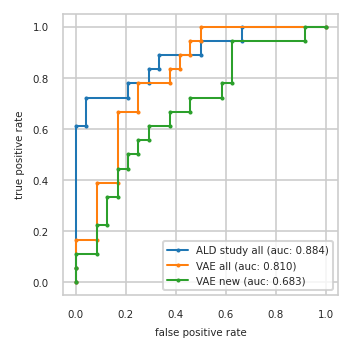

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.611   0.000 0.167   0.000 0.111
3          0.042 0.611   0.083 0.167   0.083 0.111
4          0.042 0.722   0.083 0.389   0.083 0.222
5          0.208 0.722   0.167 0.389   0.125 0.222
6          0.208 0.778   0.167 0.667   0.125 0.333
7          0.292 0.778   0.250 0.667   0.167 0.333
8          0.292 0.833   0.250 0.778   0.167 0.444
9          0.333 0.833   0.375 0.778   0.208 0.444
10         0.333 0.889   0.375 0.833   0.208 0.500
11         0.500 0.889   0.417 0.833   0.250 0.500
12         0.500 0.944   0.417 0.889   0.250 0.556
13         0.667 0.944   0.458 0.889   0.292 0.556
14         0.667 1.000   0.458 0.944   0.292 0.611
15         1.000 1.000   0.500 0.944   0.375 0.611
16           NaN   NaN   0.500 1.000   0.375 0.667
17           NaN   NaN   1.000 1.000   0.458 0.667
18           NaN   NaN     NaN   NaN   0.458 0.722
19           NaN   NaN     NaN   NaN   0.583 0.722
20           NaN   NaN     NaN   NaN   0.583 0.778
21           NaN   NaN     NaN   NaN   0.625 0.778
22           NaN   NaN     NaN   NaN   0.625 0.944
23           NaN   NaN     NaN   NaN   0.917 0.944
24           NaN   NaN     NaN   NaN   0.917 1.000
25           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P07998,Q96GD0,H0Y7T8;P49418;P49418-2
2,A0A075B6R2,B0YIW2;P02656,Q9NUQ9
3,P01033;Q5H9A7,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
4,P61981,Q9Y2T3;Q9Y2T3-3,Q96GD0
5,P04075,A0A0A0MRJ7;P12259,P31321
6,P14174,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q9Y2T3;Q9Y2T3-3,Q14894,J3KSJ8;Q9UD71;Q9UD71-2
8,P00338;P00338-3,P14174,P51688


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


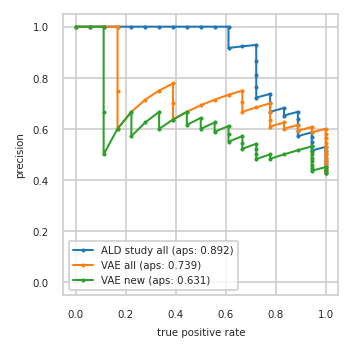

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.571 0.889     0.607 0.944     0.500 0.778
15         0.593 0.889     0.593 0.889     0.481 0.722
16         0.615 0.889     0.615 0.889     0.500 0.722
17         0.640 0.889     0.600 0.833     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.667 0.778     0.571 0.667
22         0.700 0.778     0.700 0.778     0.550 0.611
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.812 0.722     0.750 0.667     0.625 0.556
27         0.867 0.722     0.733 0.611     0.600 0.500
28         0.929 0.722     0.714 0.556     0.643 0.500
29         0.923 0.667     0.692 0.500     0.615 0.444
30         0.917 0.611     0.667 0.444     0.667 0.444
31         1.000 0.611     0.636 0.389     0.636 0.389
32         1.000 0.556     0.700 0.389     0.600 0.333
33         1.000 0.500     0.778 0.389     0.667 0.333
34         1.000 0.444     0.750 0.333     0.625 0.278
35         1.000 0.389     0.714 0.278     0.571 0.222
36         1.000 0.333     0.667 0.222     0.667 0.222
37         1.000 0.278     0.600 0.167     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


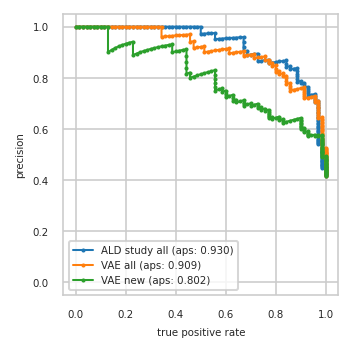

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


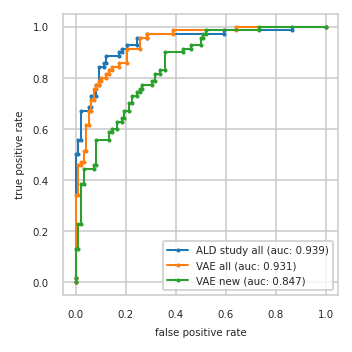

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}